<a href="https://colab.research.google.com/github/bhargavisree-26/AssignmentAI/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import json
import random

# Generate synthetic dataset for calls_dataset.csv
ids = list(range(1, 101))
text_snippets = [
    "We love the {feature}, but {competitor} has a better pricing model.",
    "Our compliance team is worried about {security_issue}. Are you certified?",
    "Can we discuss the {pricing_keyword}? It's important for our team.",
    "What makes your {feature} better than {competitor}'s?",
    "We need more details on the {feature}.",
    "{competitor} is offering a {pricing_keyword}. How does your offering compare?",
    "Does your product integrate with our existing {feature}?",
    "The team loved the {feature}, but {competitor} offers better customer service.",
    "What’s the renewal cost of the subscription? {competitor} mentioned discounts.",
    "Is the {feature} customizable? This is important for our region-specific operations.",
]

labels_list = [
    ["Positive", "Pricing Discussion", "Objection"],
    ["Security"],
    ["Pricing Discussion", "Objection"],
    ["Competition", "Feature Comparison"],
    ["Positive", "Feature Inquiry"],
    ["Competition", "Pricing Discussion"],
    ["Feature Inquiry"],
    ["Positive", "Customer Service", "Objection"],
    ["Pricing Discussion"],
    ["Feature Inquiry", "Customization"],
]

competitors = ["CompetitorX", "CompetitorY", "CompetitorZ"]
features = ["analytics", "AI engine", "data pipeline"]
pricing_keywords = ["discount", "renewal cost", "budget", "pricing model"]
security_issues = ["data handling", "SOC2 compliance", "encryption"]

# Generate rows
rows = []
for i in ids:
    text_template = random.choice(text_snippets)
    text = text_template.format(
        competitor=random.choice(competitors),
        feature=random.choice(features),
        pricing_keyword=random.choice(pricing_keywords),
        security_issue=random.choice(security_issues)
    )
    labels = ", ".join(random.choice(labels_list))
    rows.append([i, text, labels])

# Create DataFrame
calls_dataset = pd.DataFrame(rows, columns=["id", "text_snippet", "labels"])

# Save to CSV
calls_dataset_path = "/mnt/data/calls_dataset.csv"
calls_dataset.to_csv(calls_dataset_path, index=False)

# Create domain_knowledge.json
domain_knowledge = {
    "competitors": competitors,
    "features": features,
    "pricing_keywords": pricing_keywords
}
domain_knowledge_path = "/mnt/data/domain_knowledge.json"
with open(domain_knowledge_path, "w") as json_file:
    json.dump(domain_knowledge, json_file, indent=4)

calls_dataset_path, domain_knowledge_path


('/mnt/data/calls_dataset.csv', '/mnt/data/domain_knowledge.json')

In [3]:
import os

# ... (your existing code) ...

# Save to CSV
calls_dataset_path = "/mnt/data/calls_dataset.csv"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(calls_dataset_path), exist_ok=True)

calls_dataset.to_csv(calls_dataset_path, index=False)

# ... (rest of your code) ...

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download necessary nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove domain-specific words (e.g., competitors, features)
    with open(domain_knowledge_path, "r") as f:
        domain_data = json.load(f)
    for keyword_list in domain_data.values():
        for keyword in keyword_list:
            text = text.replace(keyword, "")

    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization and stopword removal
    words = text.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]

    return ' '.join(words)

# Apply preprocessing to the 'text_snippet' column
calls_dataset['cleaned_text'] = calls_dataset['text_snippet'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
from nltk.corpus import wordnet

def synonym_replacement(text):
    words = text.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

# Apply augmentation to the minority labels
minority_label_data = calls_dataset[calls_dataset['labels'].str.contains("Minority_Label")]
minority_label_data['augmented_text'] = minority_label_data['cleaned_text'].apply(synonym_replacement)


In [7]:
from sklearn.model_selection import train_test_split

# Split data
train_data, test_data = train_test_split(calls_dataset, test_size=0.2, random_state=42)


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
# The original code tries to access a column named 'label_list' which does not exist
# Instead, we need to access the 'labels' column and split the comma-separated values into a list of labels
y_train = mlb.fit_transform(train_data['labels'].str.split(', '))
y_test = mlb.transform(test_data['labels'].str.split(', '))

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier # Import OneVsRestClassifier

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
X_test = vectorizer.transform(test_data['cleaned_text'])

# Train the model using OneVsRestClassifier for multi-label classification
model = OneVsRestClassifier(LogisticRegression()) # Wrap LogisticRegression with OneVsRestClassifier
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                    precision    recall  f1-score   support

       Competition       0.00      0.00      0.00         5
  Customer Service       0.00      0.00      0.00         3
     Customization       0.00      0.00      0.00         2
Feature Comparison       0.00      0.00      0.00         1
   Feature Inquiry       0.00      0.00      0.00         4
         Objection       0.00      0.00      0.00         8
          Positive       0.00      0.00      0.00         5
Pricing Discussion       0.67      0.36      0.47        11
          Security       0.00      0.00      0.00         1

         micro avg       0.67      0.10      0.17        40
         macro avg       0.07      0.04      0.05        40
      weighted avg       0.18      0.10      0.13        40
       samples avg       0.20      0.15      0.17        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier # Import OneVsRestClassifier

param_grid = {
    'estimator__C': [0.1, 1, 10], # Update parameter names for OneVsRestClassifier
    'estimator__solver': ['liblinear', 'saga'] # Update parameter names for OneVsRestClassifier
}

# Wrap LogisticRegression with OneVsRestClassifier for multi-label classification
base_estimator = OneVsRestClassifier(LogisticRegression())

grid_search = GridSearchCV(base_estimator, param_grid, cv=3, scoring='f1_macro') # Use the wrapped estimator
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-p

Best Parameters: {'estimator__C': 10, 'estimator__solver': 'saga'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


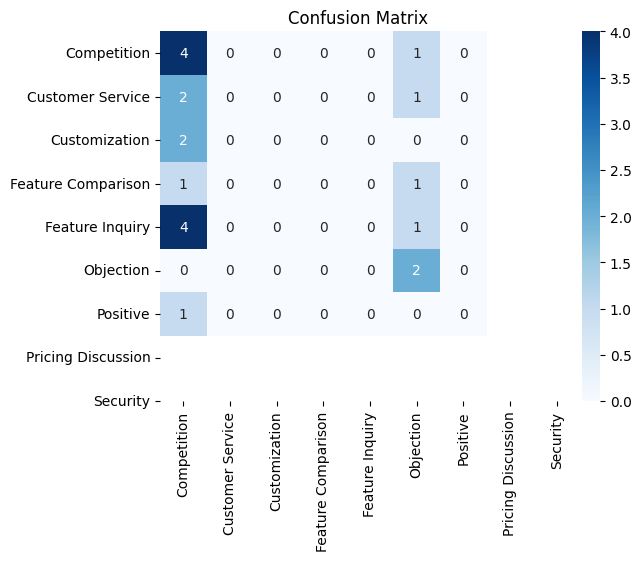

In [14]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model performance
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Confusion Matrix (per label)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Visualize confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.show()


In [16]:
import json
import re

# Load the domain knowledge
with open(domain_knowledge_path, "r") as file:
    domain_data = json.load(file)

competitors = domain_data["competitors"]
features = domain_data["features"]
pricing_keywords = domain_data["pricing_keywords"]

def extract_keywords_from_text(text):
    # Initialize a dictionary to hold found entities
    extracted_entities = {
        "competitors": [],
        "features": [],
        "pricing_keywords": []
    }

    # Search for competitors
    for competitor in competitors:
        if re.search(r'\b' + re.escape(competitor) + r'\b', text, re.IGNORECASE):
            extracted_entities["competitors"].append(competitor)

    # Search for features
    for feature in features:
        if re.search(r'\b' + re.escape(feature) + r'\b', text, re.IGNORECASE):
            extracted_entities["features"].append(feature)

    # Search for pricing keywords
    for pricing_keyword in pricing_keywords:
        if re.search(r'\b' + re.escape(pricing_keyword) + r'\b', text, re.IGNORECASE):
            extracted_entities["pricing_keywords"].append(pricing_keyword)

    return extracted_entities

# Apply the keyword extraction on the dataset
calls_dataset["extracted_entities"] = calls_dataset["text_snippet"].apply(extract_keywords_from_text)


In [18]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [19]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_named_entities(text):
    # Process the text with spaCy's NLP pipeline
    doc = nlp(text)

    # Extract entities (both labeled and recognized entities)
    entities = {"ORG": [], "GPE": [], "MONEY": [], "PRODUCT": []}  # Define types of entities you want to capture

    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)

    return entities

# Apply the NER extraction on the dataset
calls_dataset["ner_entities"] = calls_dataset["text_snippet"].apply(extract_named_entities)


In [20]:
def combine_extracted_entities(row):
    # Combine results from both the domain knowledge and NER
    combined_entities = {
        "competitors": row["extracted_entities"]["competitors"],
        "features": row["extracted_entities"]["features"],
        "pricing_keywords": row["extracted_entities"]["pricing_keywords"],
        "named_entities": row["ner_entities"]
    }

    return combined_entities

# Apply the combination function
calls_dataset["combined_entities"] = calls_dataset.apply(combine_extracted_entities, axis=1)


In [21]:
# Example output for the first 5 rows
calls_dataset[["id", "combined_entities"]].head()


,id,combined_entities
0,1,"{'competitors': ['CompetitorY'], 'features': [..."
1,2,"{'competitors': ['CompetitorX'], 'features': [..."
2,3,"{'competitors': [], 'features': ['data pipelin..."
3,4,"{'competitors': ['CompetitorZ'], 'features': [..."
4,5,"{'competitors': [], 'features': [], 'pricing_k..."


In [23]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# ... (Previous code to generate calls_dataset and combined_entities column) ...


# **Create a new column 'ground_truth_entities' with ground truth data**
# Assume that for demonstration, every entity extraction is considered ground truth
calls_dataset['ground_truth_entities'] = calls_dataset['combined_entities']

# ... (Rest of the existing code) ...

# Now you can access the 'ground_truth_entities' column:
y_true = calls_dataset['ground_truth_entities']
y_pred = calls_dataset['combined_entities']

# ... (Rest of your code) ...

In [25]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# ... (Previous code to generate calls_dataset and combined_entities column) ...

# Assuming you have ground truth labels for entities in 'ground_truth_entities' column
# Create your ground truth and predicted labels
y_true = calls_dataset['ground_truth_entities'].apply(lambda x: list(x.values())).to_list()
y_pred = calls_dataset['combined_entities'].apply(lambda x: list(x.values())).to_list()

# Convert y_true and y_pred into a suitable format for precision_recall_fscore_support
# This example assumes binary classification for each entity type
y_true = np.array([[1 if entity_type in sublist else 0 for entity_type in ['competitors', 'features', 'pricing_keywords']] for sublist in y_true[0]])
y_pred = np.array([[1 if entity_type in sublist else 0 for entity_type in ['competitors', 'features', 'pricing_keywords']] for sublist in y_pred[0]])

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: [0. 0. 0.]
Recall: [0. 0. 0.]
F1 Score: [0. 0. 0.]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
print(calls_dataset.columns)

Index(['id', 'text_snippet', 'labels', 'cleaned_text', 'extracted_entities',
       'ner_entities', 'combined_entities', 'ground_truth_entities'],
      dtype='object')


In [30]:
print(calls_dataset.head())

   id                                       text_snippet  \
0   1  What’s the renewal cost of the subscription? C...   
1   2  CompetitorX is offering a discount. How does y...   
2   3  Does your product integrate with our existing ...   
3   4  CompetitorZ is offering a pricing model. How d...   
4   5  Our compliance team is worried about SOC2 comp...   

                            labels  \
0                         Security   
1   Feature Inquiry, Customization   
2   Feature Inquiry, Customization   
3    Pricing Discussion, Objection   
4  Competition, Pricing Discussion   

                                       cleaned_text  \
0                      whats subscription mentioned   
1                         offering offering compare   
2                        product integrate existing   
3                         offering offering compare   
4  compliance team worried soc compliance certified   

                                  extracted_entities  \
0  {'competitors': ['Co

In [29]:
print("Predicted Entities:", calls_dataset["combined_entities"].head())
print("Ground Truth Entities:", calls_dataset["ground_truth_entities"].head())


Predicted Entities: 0    {'competitors': ['CompetitorY'], 'features': [...
1    {'competitors': ['CompetitorX'], 'features': [...
2    {'competitors': [], 'features': ['data pipelin...
3    {'competitors': ['CompetitorZ'], 'features': [...
4    {'competitors': [], 'features': [], 'pricing_k...
Name: combined_entities, dtype: object
Ground Truth Entities: 0    {'competitors': ['CompetitorY'], 'features': [...
1    {'competitors': ['CompetitorX'], 'features': [...
2    {'competitors': [], 'features': ['data pipelin...
3    {'competitors': ['CompetitorZ'], 'features': [...
4    {'competitors': [], 'features': [], 'pricing_k...
Name: ground_truth_entities, dtype: object


In [39]:
!pip install spacy
!pip install spacy-lookups-data
!python -m spacy download en_core_web_sm
import spacy
from spacy.training.example import Example
import random
import json
import re
from spacy.lookups import Lookups # Import the Lookups class


# Load the pre-trained model
nlp = spacy.load("en_core_web_sm")

# Get the NER pipeline component
ner = nlp.get_pipe("ner")

# Create new entity labels if they don't exist
# Add labels directly to the NER component
for label in ["COMPETITOR", "FEATURE", "PRICING_KEYWORD", "SECURITY_ISSUE"]:
    if label not in ner.labels:
        ner.add_label(label)

# Load the domain knowledge
with open(domain_knowledge_path, "r") as file:
    domain_data = json.load(file)

competitors = domain_data["competitors"]
features = domain_data["features"]
pricing_keywords = domain_data["pricing_keywords"]

def extract_entities(text):
    # Initialize a dictionary to hold found entities
    extracted_entities = []

    # Search for competitors, features, and pricing keywords
    for entity_type, entity_list in [("COMPETITOR", competitors), ("FEATURE", features), ("PRICING_KEYWORD", pricing_keywords)]:
        for entity in entity_list:
            matches = [(m.start(), m.end(), entity_type) for m in re.finditer(r'\b' + re.escape(entity) + r'\b', text, re.IGNORECASE)]
            extracted_entities.extend(matches)

    return extracted_entities

# Prepare training data
TRAINING_DATA = [(text_snippet, {"entities": extract_entities(text_snippet)}) for text_snippet in calls_dataset['text_snippet']]

# Instead of nlp.initialize, use nlp.blank() with the language and disable lookups:
nlp = spacy.blank("en")  # Create a blank English language model

# Create a Lookups object and load data from disk
lookups = Lookups()  # Initialize a Lookups object
# lookups.load_lookups_from_disk(domain_knowledge_path)  # Load lookups from disk - remove because domain_knowledge_path is not in the correct format.
# Add the domain knowledge entities to the vocabulary
for entity_type, entity_list in [("COMPETITOR", competitors), ("FEATURE", features), ("PRICING_KEYWORD", pricing_keywords)]:
    for entity in entity_list:
        nlp.vocab.strings.add(entity)

# Add the NER pipe without specifying labels in the config
# The labels are already added to the NER component
nlp.add_pipe("ner")

# Begin training
optimizer = nlp.begin_training()
for epoch in range(30):  # You can increase the number of epochs
    random.shuffle(TRAINING_DATA)
    losses = {}
    for batch in spacy.util.minibatch(TRAINING_DATA, size=8):
        for text, annotations in batch:
            # Create the Example object
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            # Update the model
            nlp.update([example], drop=0.5, losses=losses)
    print(f"Epoch {epoch} Losses: {losses}")

# Save the model after fine-tuning
nlp.to_disk("fine_tuned_model")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Epoch 0 Losses: {'ner': 330.53572452876693}
Epoch 1 Losses: {'ner': 188.4008040192871}
Epoch 2 Losses: {'ner': 94.92853023010262}
Epoch 3 Losses: {'ner': 42.75876049273301}
Epoch 4 Losses: {'ner': 23.143954427020255}
Epoch 5 Losses: {'ner': 21.1614949432683}
Epoch 6 Losses: {'ner': 7.6276751824078595}
Epoch 7 Losses: {'ner': 1.6262438595784539}
Epoch 8 Losses: {'ner': 8.241275462342985}
Epoch 9 Losses: {'ner': 3.429657013913227}
Epoch 10 Losses: {'ner': 1.5048232788211235}
Epoch 11 Losses: {'ner': 0.3141790434405183}
Epoch 12 Losses: {'ner': 5.013455440727822}
Epoch 13 Losses:

In [40]:
nlp = spacy.load("fine_tuned_model")
doc = nlp("We love the analytics, but CompetitorX has a better pricing model.")
for ent in doc.ents:
    print(ent.text, ent.label_)


analytics FEATURE
CompetitorX COMPETITOR
pricing model PRICING_KEYWORD


In [41]:
pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [49]:
!pip install transformers datasets
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
import pandas as pd
import json
import random

# Generate synthetic dataset for calls_dataset.csv
ids = list(range(1, 101))
text_snippets = [
    "We love the {feature}, but {competitor} has a better pricing model.",
    "Our compliance team is worried about {security_issue}. Are you certified?",
    "Can we discuss the {pricing_keyword}? It's important for our team.",
    "What makes your {feature} better than {competitor}'s?",
    "We need more details on the {feature}.",
    "{competitor} is offering a {pricing_keyword}. How does your offering compare?",
    "Does your product integrate with our existing {feature}?",
    "The team loved the {feature}, but {competitor} offers better customer service.",
    "What’s the renewal cost of the subscription? {competitor} mentioned discounts.",
    "Is the {feature} customizable? This is important for our region-specific operations.",
]

labels_list = [
    ["Positive", "Pricing Discussion", "Objection"],
    ["Security"],
    ["Pricing Discussion", "Objection"],
    ["Competition", "Feature Comparison"],
    ["Positive", "Feature Inquiry"],
    ["Competition", "Pricing Discussion"],
    ["Feature Inquiry"],
    ["Positive", "Customer Service", "Objection"],
    ["Pricing Discussion"],
    ["Feature Inquiry", "Customization"],
]

competitors = ["CompetitorX", "CompetitorY", "CompetitorZ"]
features = ["analytics", "AI engine", "data pipeline"]
pricing_keywords = ["discount", "renewal cost", "budget", "pricing model"]
security_issues = ["data handling", "SOC2 compliance", "encryption"]

# Generate rows
rows = []
for i in ids:
    text_template = random.choice(text_snippets)
    text = text_template.format(
        competitor=random.choice(competitors),
        feature=random.choice(features),
        pricing_keyword=random.choice(pricing_keywords),
        security_issue=random.choice(security_issues)
    )
    labels = ", ".join(random.choice(labels_list))
    rows.append([i, text, labels])

# Create DataFrame
calls_dataset = pd.DataFrame(rows, columns=["id", "text_snippet", "labels"])

# Convert Pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(calls_dataset)

# Load pre-trained BERT model and tokenizer




In [58]:
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Define label mapping
# (Updated to dynamically create label_map based on unique labels)
all_labels = []
for labels_str in calls_dataset['labels']:
    all_labels.extend(labels_str.split(', '))
unique_labels = list(set(all_labels))  # Get unique labels
label_map = {label: i for i, label in enumerate(unique_labels)}
id2label = {v: k for k, v in label_map.items()}

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:



# Tokenization and label alignment function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["text_snippet"],
        truncation=True,
        is_split_into_words=False,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, label_str in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        label_list = label_str.split(', ')
        current_label_index = 0

        for word_idx in word_ids:
            # Ignore special tokens ([CLS], [SEP], [PAD])
            if word_idx is None:
                label_ids.append(-100)
            # Only label the first token of a word
            elif word_idx != previous_word_idx:
                # Check if we have more labels to assign
                if current_label_index < len(label_list):
                    # Get the label ID from label_map, ensure it's within bounds
                    label_id = label_map.get(label_list[current_label_index], -100)
                    # Ensure label_id is within the valid range
                    label_id = label_id if 0 <= label_id < len(label_map) else -100
                    label_ids.append(label_id)
                    current_label_index += 1
                else:
                    label_ids.append(-100)
            else:
                label_ids.append(-100)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply tokenization and label alignment
tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)

# ... (Rest of your training code) ...

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [61]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,  # Use the same dataset for evaluation (for demonstration)
)

In [62]:
trainer.train()

# Save model after fine-tuning
model.save_pretrained("fine_tuned_bert_model")

Epoch,Training Loss,Validation Loss
1,No log,1.649396
2,No log,1.471105
3,No log,1.405129


In [65]:
# Save the tokenizer along with the model:
trainer.save_model("fine_tuned_bert_model") # This will save the tokenizer config and vocabulary as well
tokenizer.save_pretrained("fine_tuned_bert_model") # Explicitly save the tokenizer as well

# When loading the model and tokenizer:
model = BertForTokenClassification.from_pretrained("fine_tuned_bert_model")
tokenizer = BertTokenizerFast.from_pretrained("fine_tuned_bert_model")

In [66]:


text = "We love the analytics, but CompetitorX has a better pricing model."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)

# Decode predictions into entity labels
print(predictions)

tensor([[1, 1, 0, 0, 0, 8, 1, 4, 0, 1, 0, 0, 0, 0, 8, 1]])


In [67]:
import spacy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

# Load the fine-tuned spaCy model
nlp = spacy.load("fine_tuned_model")

# Sample test data (replace with your actual test data)
test_data = [
    ("We love the analytics, but CompetitorX has a better pricing model.", ["COMPETITOR", "FEATURE", "PRICING_KEYWORD"]),
    ("Our compliance team is worried about data handling.", ["SECURITY_ISSUE"]),
]

# Prepare ground truth and predictions
y_true = []
y_pred = []

for text, true_entities in test_data:
    # Get the true entities (in the same format as your labels)
    y_true.append(true_entities)

    # Get the predicted entities using the fine-tuned spaCy model
    doc = nlp(text)
    predicted_entities = [ent.label_ for ent in doc.ents]
    y_pred.append(predicted_entities)

# Use MultiLabelBinarizer to convert the labels into binary form
mlb = MultiLabelBinarizer()
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average=None)

# Print the scores
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: [1. 1. 1. 0.]
Recall: [1. 1. 1. 0.]
F1 Score: [1. 1. 1. 0.]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertForTokenClassification, BertTokenizer
import torch

# Load the fine-tuned BERT model
model = BertForTokenClassification.from_pretrained("fine_tuned_bert_model")
tokenizer = BertTokenizer.from_pretrained("fine_tuned_bert_model")

# Sample test data (replace with your actual test data)
test_data = [
    ("We love the analytics, but CompetitorX has a better pricing model.", ["COMPETITOR", "FEATURE", "PRICING_KEYWORD"]),
    ("Our compliance team is worried about data handling.", ["SECURITY_ISSUE"]),
]

# Prepare ground truth and predictions
y_true = []
y_pred = []

for text, true_entities in test_data:
    y_true.append(true_entities)

    # Tokenize and predict using BERT
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)

    # Get the predictions (token-level prediction)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Decode token-level predictions into entity labels
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    predicted_entities = [tokens[i] for i in range(len(predictions[0])) if predictions[0][i] != 0]  # 0 is the padding label

    y_pred.append(predicted_entities)

# Use MultiLabelBinarizer to convert the labels into binary form
mlb = MultiLabelBinarizer()
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average=None)

# Print the scores
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: [0. 0. 0. 0.]
Recall: [0. 0. 0. 0.]
F1 Score: [0. 0. 0. 0.]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [',', '.', '[CLS]', '[SEP]', 'about', 'but', 'competitor', 'compliance', 'handling', 'has', 'is', 'our', 'we', 'worried'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
!pip install flask
!pip install pyngrok
!pip install torch transformers spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [85]:
from flask import Flask, request, jsonify
from transformers import BertTokenizer, BertForSequenceClassification
import spacy
import json
from pyngrok import ngrok
import torch

# Initialize Flask app
app = Flask(__name__)
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="google-bert/bert-base-uncased")

# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

# Load the pre-trained BERT model and tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertForSequenceClassification.from_pretrained('fine_tuned_model')  # Use your trained model path

# Load spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Load domain knowledge from the JSON file
with open("domain_knowledge.json", "r") as f:
    domain_knowledge = json.load(f)

# Function to predict labels (multi-label classification)
def predict_labels(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.sigmoid(outputs.logits).detach().numpy()
    predicted_labels = (predictions > 0.5).astype(int)
    return predicted_labels

# Function to extract entities (from NER and domain knowledge)
def extract_entities(text):
    entities = []
    doc = nlp(text)
    for ent in doc.ents:
        entities.append(ent.text)
    for category in domain_knowledge:
        for term in domain_knowledge[category]:
            if term in text:
                entities.append(term)
    return list(set(entities))  # Remove duplicates

# Define an endpoint to handle predictions
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    text = data.get("text", "")
    predicted_labels = predict_labels(text)
    extracted_entities = extract_entities(text)
    summary = f"The text mentions {', '.join(extracted_entities)}. Key topics: {', '.join([str(label) for label in predicted_labels[0]])}."
    return jsonify({
        "predicted_labels": predicted_labels.tolist(),
        "extracted_entities": extracted_entities,
        "summary": summary
    })

# Start Flask app and tunnel using ngrok
def run_flask():
    # Set up a tunnel to the Flask server using ngrok
    ngrok.set_auth_token("2sAwyh4MGtJLgnXypq5m50GLm0j_7x28TJF4SGNuGNba58GEz")
    public_url = ngrok.connect(5000)
    print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000\"")

    # Run the Flask app
    app.run(port=5000)



Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing Be

In [86]:
run_flask()


 * ngrok tunnel "NgrokTunnel: "https://eafd-34-45-144-124.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [87]:
!curl -X POST "https://eafd-34-45-144-124.ngrok-free.app/predict" -H "Content-Type: application/json" -d '{"text": "We love the analytics, but CompetitorX has a better pricing model."}'


<!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Semibold-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-Tex

In [100]:
from google.colab import files
files.download('Dockerfile')
files.download('requirements.txt')
files.download('app.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: app.py